In [1]:
import glob 
import os
from langchain_community.llms import Ollama
import base64
from io import BytesIO
from IPython.display import HTML, display
from PIL import Image
from langchain.prompts.few_shot import FewShotPromptTemplate
from langchain.prompts.prompt import PromptTemplate
from langchain_core.output_parsers import StrOutputParser
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def find_data(CK=False, JAFFE=False, FER2013=False, neutral=False):
    emo_dict = {"anger":0, "contempt":0, "disgust":0, "fear":0, "happiness":0, "neutral":0, "sadness":0, "surprise":0}
    list_paths = []

    # CK+ load
    if CK:
        for emotion in ["anger", "contempt", "disgust", "fear", "happiness", "neutral", "sadness", "surprise"]:
            if emotion is "neutral" and not neutral:
                continue
            emo_folder_path = "../Polygence/Datasets/CK+/" + emotion
            for pic_file in glob.glob(os.path.join(emo_folder_path, "*png")):
                list_paths.append([emotion, pic_file])

    # JAFFE load
    if JAFFE:
        for pic_file in glob.glob(os.path.join("../Polygence/Datasets/JAFFE", "*tiff")):
            if "AN" in pic_file[26:]:
                list_paths.append(["anger", pic_file])
            elif "DI" in pic_file[26:]:
                list_paths.append(["disgust", pic_file])
            elif "FE" in pic_file[26:]:
                list_paths.append(["fear", pic_file])
            elif "HA" in pic_file[26:]:
                list_paths.append(["happiness", pic_file])
            elif "NE" in pic_file[26:]:
                list_paths.append(["neutral", pic_file])
            elif "SA" in pic_file[26:]:
                list_paths.append(["sadness", pic_file])
            else:
                list_paths.append(["surprise", pic_file])

    #FER-2013
    if FER2013:
        FER_emo_dict = {0:"anger", 1:"disgust", 2:"fear", 3:"happiness", 4:"neutral", 5:"sadness", 6:"surprise"}
        for set in ["test/", "train/"]:
            root = "../Polygence/Datasets/FER2013/" + set
            for index, emotion in enumerate(["angry", "disgust", "fear", "happy", "neutral", "sad", "surprise"]):
                emo_folder_path = root + emotion
                for pic_file in glob.glob(os.path.join(emo_folder_path, "*jpg")):
                    list_paths.append([FER_emo_dict[index], pic_file])   
    for (a,b) in list_paths:
        emo_dict[a] +=1
    print(emo_dict)
    return list_paths
def convert_to_base64(pil_image):
    """
    Convert PIL images to Base64 encoded strings

    :param pil_image: PIL image
    :return: Re-sized Base64 string
    """

    buffered = BytesIO()
    pil_image.save(buffered, format="JPEG")  # You can change the format if needed
    img_str = base64.b64encode(buffered.getvalue()).decode("utf-8")
    return img_str
def plt_img_base64(img_base64):
    """
    Display base64 encoded string as image

    :param img_base64:  Base64 string
    """
    # Create an HTML img tag with the base64 string as the source
    image_html = f'<img src="data:image/jpeg;base64,{img_base64}" />'
    # Display the image by rendering the HTML
    display(HTML(image_html))
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=False,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.

    Arguments
    ---------
    cf:            confusion matrix to be passed in

    group_names:   List of strings that represent the labels row by row to be shown in each square.

    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'

    count:         If True, show the raw number in the confusion matrix. Default is True.

    normalize:     If True, show the proportions for each category. Default is True.

    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.

    xyticks:       If True, show x and y ticks. Default is True.

    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.

    sum_stats:     If True, display summary statistics below the figure. Default is True.

    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.

    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.

    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.1%}".format(value) for value in cf.flatten()]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = correct/total

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = (12,9)

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

<>:8: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:8: SyntaxWarning: "is" with a literal. Did you mean "=="?
/var/folders/d6/73t68jg509l9qqjp_k_6st940000gq/T/ipykernel_11104/329165652.py:8: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if emotion is "neutral" and not neutral:


In [3]:
#Function
def help(path, chain):

    file_path = path
    #print(CK[100][0])
    pil_image = Image.open(file_path)
    image_b64 = convert_to_base64(pil_image)
    #plt_img_base64(image_b64)
    input = f"""Answer the question based only on the following image:
        {image_b64}
        Question: Choose the answer that best represents the emotion on the person's face in the picture:
        0: anger
        1: contempt
        2: disgust
        3: fear
        4: happiness
        5: sadness
        6: surprise"""

    return chain.invoke({"input": input})

In [25]:
# Create Chain

from langchain.chains import LLMChain
from langchain.prompts import PromptTemplate


template ="""
Step1 :
 
I need to predict the facial emotion in this image: {input}. Could you brainstorm three distinct emotions from anger, contempt, disgust, fear, happiness, sadness, and surprise? Please consider a variety of factors such as the position of the person's eyebrows, mouth, eyes, and nose.
A:
"""

prompt = PromptTemplate(
    input_variables=["input"],
    template = template                      
)

chain1 = LLMChain(
    llm=Ollama(model="llava"),
    prompt=prompt,
    output_key="solutions"
)

template ="""
Step 2:

For each of the three proposed solutions, evaluate how true they are to the input image. Consider whether the described positions of the person's eyebrows, mouth, eyes, and nose are actually true. Assign a probability of success and a confidence level to each option based on these factors.

{solutions}

A:"""

prompt = PromptTemplate(
    input_variables=["solutions"],
    template = template                      
)

chain2 = LLMChain(
    llm=Ollama(temperature=0, model="llava"),
    prompt=prompt,
    output_key="review"
)

template ="""
Step 3:

For each solution, deepen the thought process. Verify that the described positions of eyes, mouth, eyebrows, and nose accurately describe the predicted emotion.

{review}

A:"""

prompt = PromptTemplate(
    input_variables=["review"],
    template = template                      
)

chain3 = LLMChain(
    llm=Ollama(temperature=0, model="llava"),
    prompt=prompt,
    output_key="deepen_thought_process"
)

template ="""
Step 4:

Based on the evaluations and scenarios, rank the emotions in order of promise. Only respond in one word with the most likely emotion, one of anger, contempt, disgust, fear, happiness, sadness, and surprise. 
{deepen_thought_process}

A:"""

prompt = PromptTemplate(
    input_variables=["deepen_thought_process"],
    template = template                      
)

chain4 = LLMChain(
    llm=Ollama(temperature=0, model="llava"),
    prompt=prompt,
    output_key="emotion"
)

In [26]:
from langchain.chains import SequentialChain

overall_chain = SequentialChain(
    chains=[chain1, chain2, chain3, chain4],
    input_variables=["input"],
    output_variables=["emotion"],
    verbose=True
)

In [27]:
# 1 example
#{'anger': 45, 'contempt': 18, 'disgust': 59, 'fear': 25, 'happiness': 69, 'neutral': 0, 'sadness': 28, 'surprise': 83}
#first angry = 0, contempt = 45, disgust = 63, fear = 122, happiness=147, sadness=216, surprise=244
sample_path = CK[216][1] # Weakest is sadness at 0%
sample = Image.open(sample_path)
sample_b64 = convert_to_base64(sample)

overall_chain.invoke({"input":sample_b64})['emotion']



> Entering new SequentialChain chain...

> Finished chain.


' Anger '

In [ ]:
#Setup data
CK = find_data(CK=True, JAFFE=False, FER2013=False, neutral=False)
{'anger': 45, 'contempt': 18, 'disgust': 59, 'fear': 25, 'happiness': 69, 'neutral': 0, 'sadness': 28, 'surprise': 83}
sample_paths = [CK[i] for i in [0,45,64,122,147,216,244]]
sample_images = []
for [emo, path] in sample_paths:
    sample = Image.open(path)
    sample_b64 = convert_to_base64(sample)
    sample_images.append(sample_b64)
    print(emo)
    plt_img_base64(sample_b64)

In [36]:
import time
emo_dict = {"anger":0, "contempt":1, "disgust":2, "fear":3, "happiness":4, "sadness":5, "surprise":6}
heat_matrix = [[0,0,0,0,0,0,0],[0,0,0,0,0,0,0],[0,0,0,0,0,0,0],[0,0,0,0,0,0,0],[0,0,0,0,0,0,0],[0,0,0,0,0,0,0],[0,0,0,0,0,0,0]]

correct = 0
total = 0

for emo, path in CK:
    sample = Image.open(path)
    sample_b64 = convert_to_base64(sample)
    emo_hat = overall_chain.invoke(sample_b64)['emotion'].strip().lower()
    time.sleep(0.5)
    print(emo, emo_hat)
    if emo_hat in ["anger", "contempt", "disgust", "fear", "happiness", "sadness", "surprise"]: 
        heat_matrix[emo_dict[emo]][emo_dict[emo_hat]] +=1
        if emo_dict[emo_hat]==emo_dict[emo]:
            correct +=1
    total +=1 
    print(emo, emo_hat)
    if total%10==0:
        print(total, correct/total)
    if total==1:
        print(total, correct/total, emo, emo_hat)
    if total==2:
        print(total, correct/total, emo, emo_hat)



> Entering new SequentialChain chain...

> Finished chain.
anger anger
anger anger
1 1.0 anger anger


> Entering new SequentialChain chain...

> Finished chain.
anger anger
anger anger
2 1.0 anger anger


> Entering new SequentialChain chain...

> Finished chain.
anger anger
anger anger


> Entering new SequentialChain chain...

> Finished chain.
anger anger
anger anger


> Entering new SequentialChain chain...

> Finished chain.
anger disgust
anger disgust


> Entering new SequentialChain chain...

> Finished chain.
anger anger
anger anger


> Entering new SequentialChain chain...

> Finished chain.
anger contempt
anger contempt


> Entering new SequentialChain chain...

> Finished chain.
anger anger
anger anger


> Entering new SequentialChain chain...

> Finished chain.
anger anger
anger anger


> Entering new SequentialChain chain...

> Finished chain.
anger neutral
anger neutral
10 0.7


> Entering new SequentialChain chain...

> Finished chain.
anger anger
anger anger


> Ente

KeyboardInterrupt: 

In [39]:
print(heat_matrix)

[[32, 2, 1, 3, 0, 0, 2], [15, 1, 0, 0, 0, 1, 1], [43, 1, 1, 1, 0, 5, 6], [16, 1, 2, 0, 1, 2, 1], [48, 4, 1, 1, 2, 5, 2], [17, 3, 0, 0, 2, 2, 3], [33, 1, 7, 1, 0, 7, 2]]


In [38]:
for emo, path in CK[84:]:
    sample = Image.open(path)
    sample_b64 = convert_to_base64(sample)
    emo_hat = overall_chain.invoke(sample_b64)['emotion'].strip().lower()
    time.sleep(0.5)
    print(emo, emo_hat)
    if emo_hat in ["anger", "contempt", "disgust", "fear", "happiness", "sadness", "surprise"]: 
        heat_matrix[emo_dict[emo]][emo_dict[emo_hat]] +=1
        if emo_dict[emo_hat]==emo_dict[emo]:
            correct +=1
    total +=1 
    print(emo, emo_hat)
    if total%10==0:
        print(total, correct/total)
    if total==1:
        print(total, correct/total, emo, emo_hat)
    if total==2:
        print(total, correct/total, emo, emo_hat)



> Entering new SequentialChain chain...

> Finished chain.
disgust anger
disgust anger


> Entering new SequentialChain chain...

> Finished chain.
disgust anger
disgust anger


> Entering new SequentialChain chain...

> Finished chain.
disgust anger
disgust anger


> Entering new SequentialChain chain...

> Finished chain.
disgust anger
disgust anger


> Entering new SequentialChain chain...

> Finished chain.
disgust anger
disgust anger


> Entering new SequentialChain chain...

> Finished chain.
disgust anger
disgust anger


> Entering new SequentialChain chain...

> Finished chain.
disgust anger
disgust anger
90 0.37777777777777777


> Entering new SequentialChain chain...

> Finished chain.
disgust sadness
disgust sadness


> Entering new SequentialChain chain...

> Finished chain.
disgust fear
disgust fear


> Entering new SequentialChain chain...

> Finished chain.
disgust anger
disgust anger


> Entering new SequentialChain chain...

> Finished chain.
disgust surprise
disgust

KeyboardInterrupt: 

In [42]:
emo,path= CK[83]
sample = Image.open(path)
sample_b64 = convert_to_base64(sample)
emo_hat = overall_chain.invoke(sample_b64)['emotion'].strip().lower()
time.sleep(0.5)
print(emo, emo_hat)
if emo_hat in ["anger", "contempt", "disgust", "fear", "happiness", "sadness", "surprise"]: 
    heat_matrix[emo_dict[emo]][emo_dict[emo_hat]] +=1
    if emo_dict[emo_hat]==emo_dict[emo]:
        correct +=1
total +=1 
print(emo, emo_hat)
if total%10==0:
    print(total, correct/total)
if total==1:
    print(total, correct/total, emo, emo_hat)
if total==2:
    print(total, correct/total, emo, emo_hat)



> Entering new SequentialChain chain...

> Finished chain.
disgust anger
disgust anger


In [43]:
for emo, path in CK[301:]:
    sample = Image.open(path)
    sample_b64 = convert_to_base64(sample)
    emo_hat = overall_chain.invoke(sample_b64)['emotion'].strip().lower()
    time.sleep(0.5)
    print(emo, emo_hat)
    if emo_hat in ["anger", "contempt", "disgust", "fear", "happiness", "sadness", "surprise"]: 
        heat_matrix[emo_dict[emo]][emo_dict[emo_hat]] +=1
        if emo_dict[emo_hat]==emo_dict[emo]:
            correct +=1
    total +=1 
    print(emo, emo_hat)
    if total%10==0:
        print(total, correct/total)
    if total==1:
        print(total, correct/total, emo, emo_hat)
    if total==2:
        print(total, correct/total, emo, emo_hat)



> Entering new SequentialChain chain...

> Finished chain.
surprise anger
surprise anger


> Entering new SequentialChain chain...

> Finished chain.
surprise anger
surprise anger


> Entering new SequentialChain chain...

> Finished chain.
surprise anger
surprise anger


> Entering new SequentialChain chain...

> Finished chain.
surprise neutral
surprise neutral


> Entering new SequentialChain chain...

> Finished chain.
surprise anger
surprise anger


> Entering new SequentialChain chain...

> Finished chain.
surprise anger
surprise anger


> Entering new SequentialChain chain...

> Finished chain.
surprise sadness
surprise sadness


> Entering new SequentialChain chain...

> Finished chain.
surprise anger
surprise anger


> Entering new SequentialChain chain...

> Finished chain.
surprise anger
surprise anger
310 0.12903225806451613


> Entering new SequentialChain chain...

> Finished chain.
surprise surprise
surprise surprise


> Entering new SequentialChain chain...

> Finishe

In [44]:
print(heat_matrix)

[[32, 2, 1, 3, 0, 0, 2], [15, 1, 0, 0, 0, 1, 1], [44, 1, 1, 1, 0, 5, 6], [16, 1, 2, 0, 1, 2, 1], [48, 4, 1, 1, 2, 5, 2], [17, 3, 0, 0, 2, 2, 3], [51, 1, 8, 1, 1, 9, 4]]


[[0.711 0.044 0.022 0.066 0.    0.    0.044]
 [0.833 0.055 0.    0.    0.    0.055 0.055]
 [0.745 0.016 0.016 0.016 0.    0.084 0.101]
 [0.64  0.04  0.08  0.    0.04  0.08  0.04 ]
 [0.695 0.057 0.014 0.014 0.028 0.072 0.028]
 [0.607 0.107 0.    0.    0.071 0.071 0.107]
 [0.614 0.012 0.096 0.012 0.012 0.108 0.048]]
0.12844036697247707


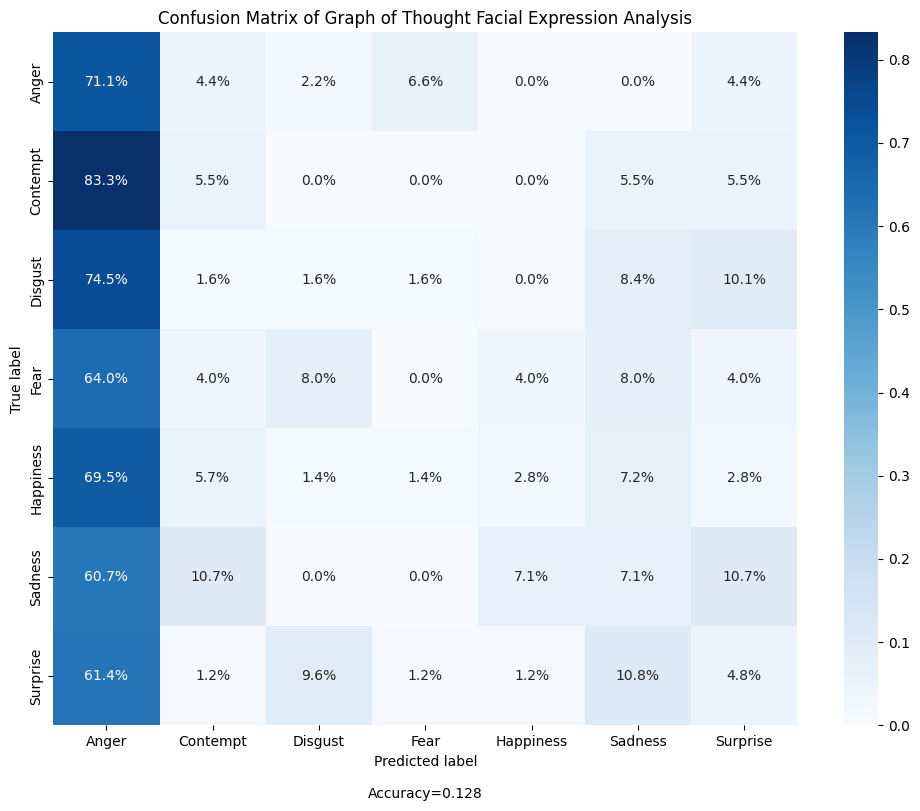

In [46]:
def truncate(n, decimals=0):
    multiplier = 10**decimals
    return int(n * multiplier) / multiplier

counts = [45, 18, 59,25,69,28,83]

heatmap_matrix = [[truncate(m/counts[n],3) for m in i] for n,i in enumerate(heat_matrix)]
make_confusion_matrix(np.array(heatmap_matrix), title="Confusion Matrix of Graph of Thought Facial Expression Analysis", categories=["Anger", "Contempt", "Disgust", "Fear", "Happiness", "Sadness", "Surprise"])

print(np.array(heatmap_matrix))
print(correct/total)